# Simulate a moving object

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from filterpy.stats import plot_covariance_ellipse
from filterpy.common import Saver

class PosSensor(object):
    def __init__(self, pos=(0.0,0.0), vel=(0.0,0.0), noise_std=1.0):
        self.pos = [pos[0], pos[1]]
        self.vel = vel
        self.noise_std = noise_std

    def read(self):
        self.pos[0] += self.vel[0] #vel = pos_k = vel * 1 second
        self.pos[1] += self.vel[1] #vel = pos_k = vel * 1 second

        return [self.pos[0] + (np.random.randn() * self.noise_std),
               self.pos[1] + (np.random.randn() * self.noise_std)]
                

# Generate a simulated measurements

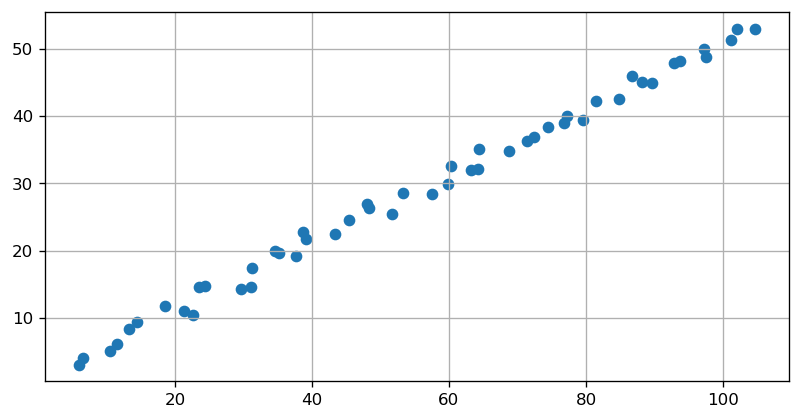

In [2]:
pos, vel = (4,3), (2,1)
sensor = PosSensor(pos=pos, vel=vel, noise_std=1.)
ps = np.array([sensor.read() for iteration in range(50)])

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.scatter(x=ps[:,:1], y=ps[:,1:], )
ax.grid(visible=True)
plt.show()

# Design a state transition matrix (how the state evolves)

In [3]:
tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.0 # time step 1 second

tracker.F = np.array([[1, dt, 0, 0],
                      [0, 1, 0, 0 ],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]])

# Design the process noise matrix

In [4]:
q = Q_discrete_white_noise(dim=2, dt=dt, var = 0.001)
tracker.Q = block_diag(q,q)
tracker.Q

array([[0.00025, 0.0005 , 0.     , 0.     ],
       [0.0005 , 0.001  , 0.     , 0.     ],
       [0.     , 0.     , 0.00025, 0.0005 ],
       [0.     , 0.     , 0.0005 , 0.001  ]])

# Design the Control Function

In [5]:
### Initially assumed to be zero
tracker.B

# Design the Measurement Function (converts the state variables into measurement space / units)

In [6]:
# for this problem, the measurement is in feet while the state variable is in meters. So we need to convert meters in to feet
tracker.H = np.array([[1/0.3048, 0, 0, 0],
                      [0, 0, 1/0.3048, 0]])

# Design the Measurement Noise matrix (Sensor noise)

In [7]:
tracker.R = np.array([[5.0, 0.0],
                      [0.0, 5.0]])
tracker.R

array([[5., 0.],
       [0., 5.]])

# Initial Conditions

In [8]:
tracker.x = np.array([[0, 0, 0, 0]])
tracker.P = np.eye(4) * 500

tracker.x

array([[0, 0, 0, 0]])

In [9]:
tracker.P

array([[500.,   0.,   0.,   0.],
       [  0., 500.,   0.,   0.],
       [  0.,   0., 500.,   0.],
       [  0.,   0.,   0., 500.]])

# Implementation of the Kalman Filter Designs

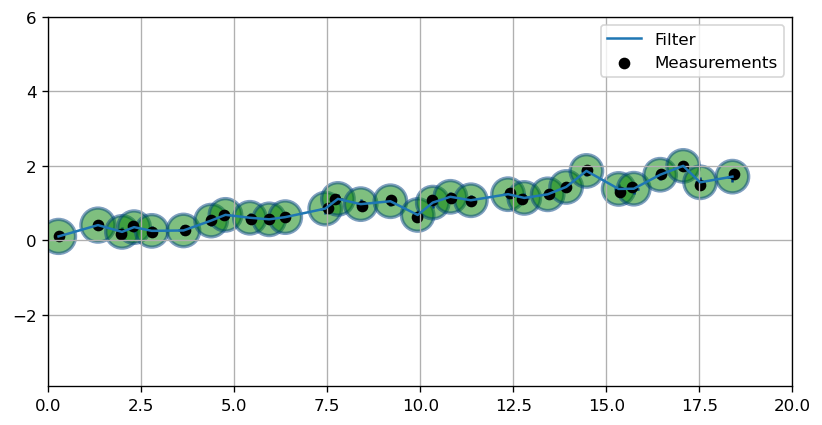

In [10]:
fig, ax = plt.subplots(figsize=(8,4), dpi=120)
R_std = 0.5
Q_std = 0.5

def tracker1():
    tracker = KalmanFilter(dim_x = 4, dim_z = 2)
    dt = 1.0 #time step

    tracker.F = np.array([[1, dt, 0, 0],
                          [0, 1, 0, 0],
                          [0, 0, 1, dt],
                          [0, 0, 0, 1]])

    tracker.u = 0 # set the control input to zero since we do not interact with the system
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * np.square(R_std) # measurement/sensor noise
    q = Q_discrete_white_noise(dim=2, dt=dt, var=np.square(Q_std))
    tracker.Q = block_diag(q,q) # process/prediction error/noise
    tracker.x = np.array([[0.0, 0.0, 0.0, 0.0]]).T
    tracker.P = np.eye(4) * 500.

    return tracker

# simulate object movement
N = 30
sensor = PosSensor(pos=(0.0, 0.0), vel=(2.0, 0.2), noise_std=R_std)

zs = np.array([sensor.read() for iteration in range(N)])

#run filter
object_tracker = tracker1()
mu, cov, _, _, = object_tracker.batch_filter(zs)

for x, P in zip(mu,cov):
    # covariance of x and y
    cov = np.array([[P[0,0], P[2,0]],
                    [P[0,2], P[2,2]]])
    mean = (x[0,0], x[2,0])

    plot_covariance_ellipse(mean, cov=cov, fc='green', std=3, alpha=0.5)

# plot the results
zs = zs * 0.3048

ax.plot(mu[:,0], mu[:,2], label='Filter') # plot the filter
ax.scatter(x=zs[:,0], y=zs[:,1], fc='black', label='Measurements') # plot the measurements
ax.set_xlim(0,20)
ax.grid(visible=True)
plt.legend()
plt.show()

In [11]:
object_tracker.P

array([[0.02114517, 0.02280673, 0.        , 0.        ],
       [0.02280673, 0.10678654, 0.        , 0.        ],
       [0.        , 0.        , 0.02114517, 0.02280673],
       [0.        , 0.        , 0.02280673, 0.10678654]])

# Simulate a Kalman Filter using a wrong process model for the order of system being filtered

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


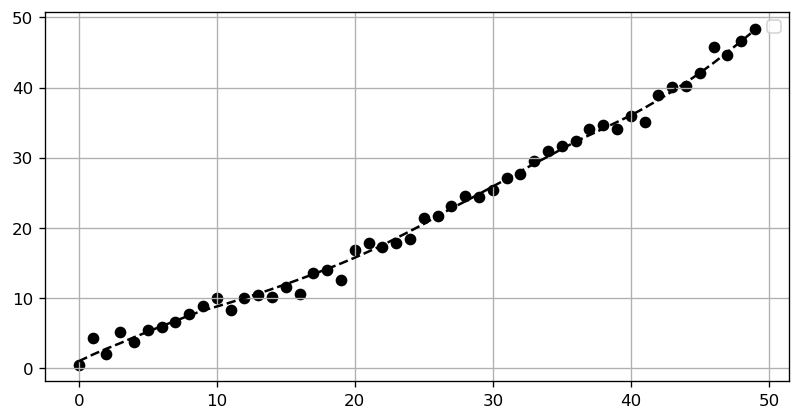

In [12]:
class ConstantVelocityObject(object):
    def __init__(self, x0=0.0, vel=1.0, noise_scale=0.06):
        self.x = x0
        self.vel = vel
        self.noise_scale = noise_scale

    def update(self):
        self.vel += np.random.randn() * self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)

def sense(x, noise_scale=1.0):
    return x[0] + (np.random.randn() * noise_scale)

np.random.seed(124)
obj = ConstantVelocityObject()

xs, zs = [], []
for iteration in range(50):
    x = obj.update()
    z = sense(x)
    xs.append(x)
    zs.append(z)

xs = np.asarray(xs)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(list(range(len(xs))),xs[:,0], c = 'black', linestyle="--")
ax.scatter(list(range(len(xs))),zs, c="black")
ax.grid(visible=True)
plt.legend()
plt.show()

In [13]:
def ZeroOrderKF(R, Q, P=20):
    """
    Create Zero Order Kalman Filter.
    Specify R and Q as Floats (since we're dealing with 1-D)
    """

    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([0.0])
    kf.R *= R
    kf.Q *= Q
    kf.P *= P
    kf.F = np.eye(1)
    kf.H = np.eye(1)
    return kf

In [14]:
def FirstOrderKF(R, Q, dt):
    """
    Create First Order Kalman Filter.
    Specify R and Q as Floats (since we're dealing with 1-D)
    """

    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P = np.array([[100,0],
                     [0,1]])
    kf.F = np.array([[1,dt],
                    [0,1]])
    kf.Q *= Q_discrete_white_noise(dim=2,dt=dt,var=Q)

    kf.R *= R
    kf.H = np.array([[1.0, 0.0]])
    
    return kf

In [48]:
def SecondOrderKF(R_std, Q_std, dt, P=100):
    """
    Create Second Order Kalman Filter.
    Specify R and Q as Floats (since we're dealing with 1-D)
    """

    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P = np.array([[P, 0.0, 0.0],
                     [0.0, 1.0, 0.0],
                     [0.0, 0.0, 1.0]])
    
    kf.F = np.array([[1.0, dt, 0.5*(dt**2)],
                    [0.0, 1.0, dt],
                     [0.0, 0.0, 1.0]])
    
    kf.Q *= Q_discrete_white_noise(dim=3,dt=dt,var=Q_std)

    kf.R *= R_std**2
    kf.H = np.array([[1.0, 0.0, 0.0]])
    
    return kf

In [16]:
def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=0.0, vel=0.5, noise_scale=Q)
    xs, zs = [], []
    for iteration in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)

    return np.array(xs), np.array(zs)

In [17]:
def filter_data(kf,zs):
    s = Saver(kf)
    kf.batch_filter(zs,saver=s)
    s.to_array()
    return s

## First Order (Correct Order)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


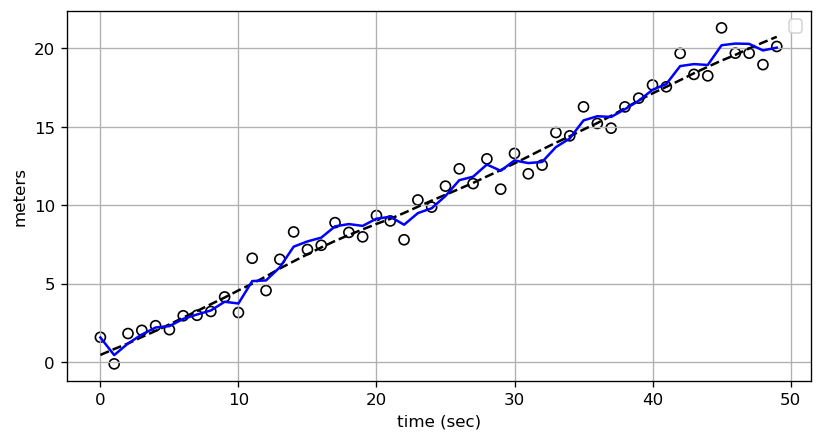

In [18]:
R, Q = 1.0, 0.03
xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R=R,Q=Q,dt=1.0)
data1 = filter_data(kf,zs)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(list(range(50)),xs[:,0], c = 'black', linestyle="--") # track
ax.scatter(list(range(len(xs))),zs, fc='none', ec="black") # measurements
ax.plot(list(range(50)),data1.x[:,0], c='blue'),
ax.set_xlabel('time (sec)')
ax.set_ylabel('meters')
ax.grid(visible=True)
plt.legend()
plt.show()

## Plot the Residuals

In [19]:
def plot_residuals(xs, data, col, title, stds):
    res = xs - data.x[:,col]
    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    ax.plot(res, c = 'blue', linestyle="--") # residual

    # generate max-min residuals
    max_res = np.array([np.sqrt(var) * stds for var in data.P[:,col,col]])
    min_res = (-1) * max_res
    
    ax.plot(max_res, c="black", linestyle="--") # measurements
    ax.plot(min_res, c="black", linestyle="--") # measurements

    ax.fill_between(x = np.arange(len(max_res)),y1=min_res,y2=max_res, fc='yellow',alpha=0.2)

    ax.set_xlabel('time (sec)')
    ax.set_ylabel('meters')
    ax.set_title(title)
    ax.grid(visible=True)

    plt.show()

### Plot the First Order Position Residuals

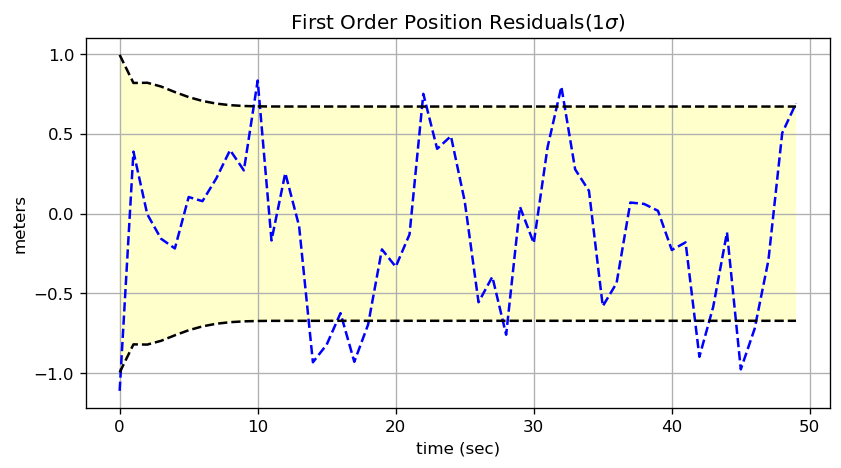

In [20]:
plot_residuals(xs[:,0], data1, 0, f"First Order Position Residuals(1$\sigma$)", stds=1.0)

### Plot the First Order Velocity Residuals

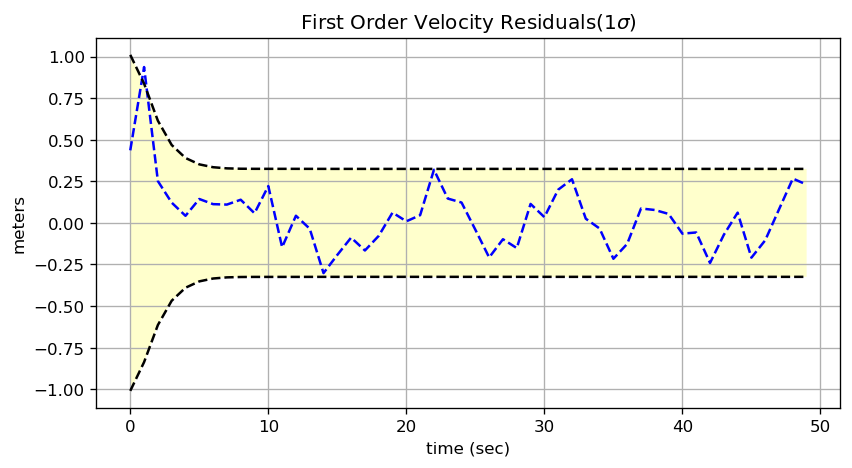

In [21]:
plot_residuals(xs[:,1], data1, 1, f"First Order Velocity Residuals(1$\sigma$)", stds=1.0)

## Zero Order (One order lower than the correct order)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


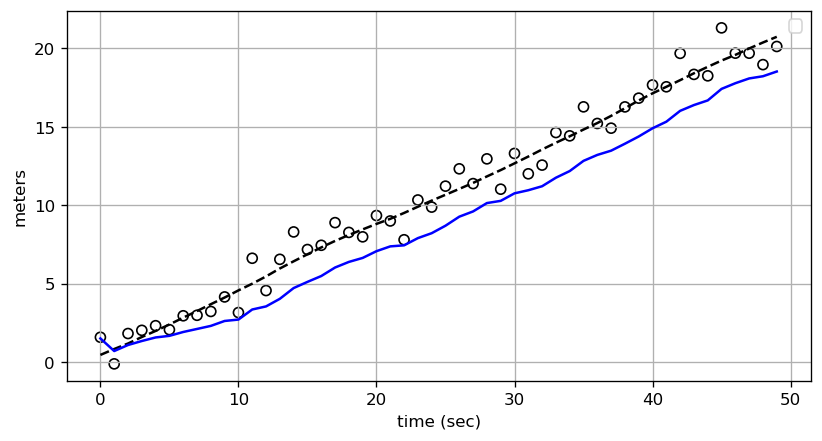

In [22]:
kf0 = ZeroOrderKF(R=R,Q=Q)
data0 = filter_data(kf0,zs)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(list(range(50)),xs[:,0], c = 'black', linestyle="--") # track
ax.scatter(list(range(len(xs))),zs, fc='none', ec="black") # measurements
ax.plot(list(range(50)),data0.x[:,0], c='blue') # Filtered results
ax.set_xlabel('time (sec)')
ax.set_ylabel('meters')
ax.grid(visible=True)
plt.legend()
plt.show()

### Plot the Zero Order Position Residuals

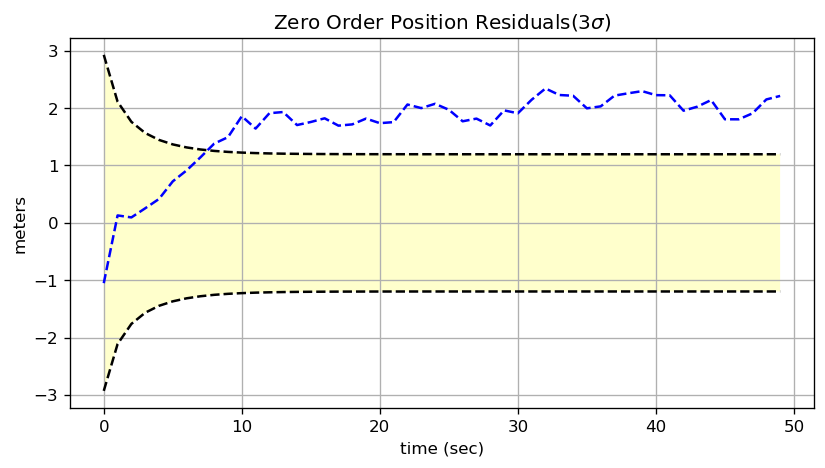

In [23]:
plot_residuals(xs[:,0], data0, 0, title=f"Zero Order Position Residuals(3$\sigma$)", stds=3.0)

## Second Order (One order higher than the correct order)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


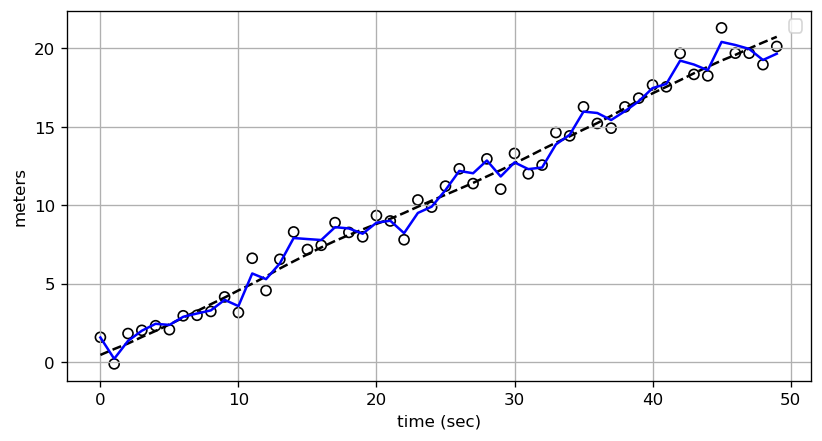

In [49]:
kf2 = SecondOrderKF(R_std=R,Q_std=Q,dt=dt)
data2 = filter_data(kf2,zs)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(list(range(50)),xs[:,0], c = 'black', linestyle="--") # track
ax.scatter(list(range(len(xs))),zs, fc='none', ec="black") # measurements
ax.plot(list(range(50)),data2.x[:,0], c='blue') # Filtered results
ax.set_xlabel('time (sec)')
ax.set_ylabel('meters')
ax.grid(visible=True)
plt.legend()
plt.show()

### Plot the Second Order Position Residuals

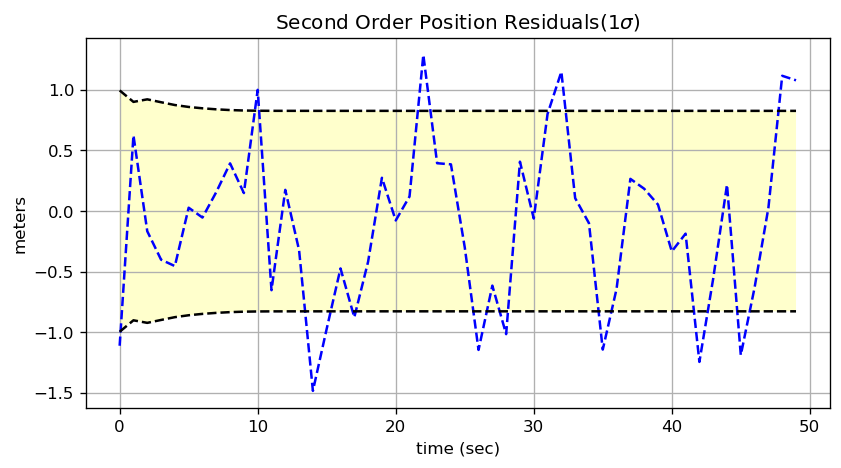

In [25]:
plot_residuals(xs[:,0], data2, 0, title="Second Order Position Residuals(1$\sigma$)", stds=1.0)

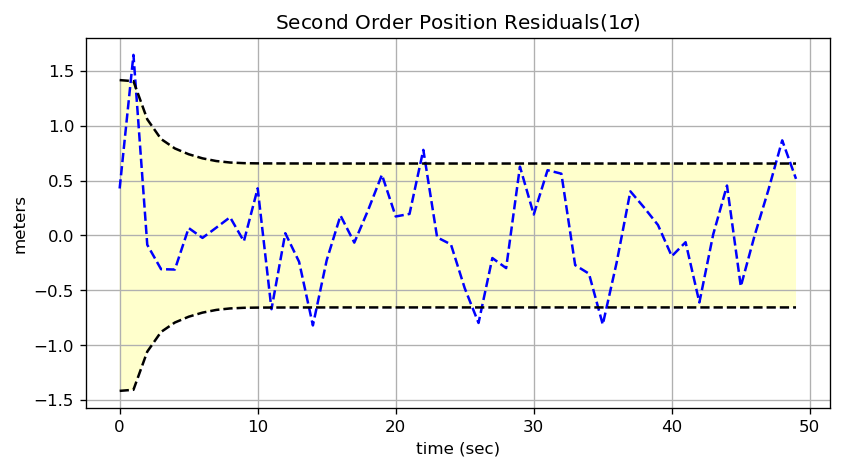

In [26]:
plot_residuals(xs[:,1], data2, 1, title="Second Order Position Residuals(1$\sigma$)", stds=1.0)

## Second Order but with zero Q

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


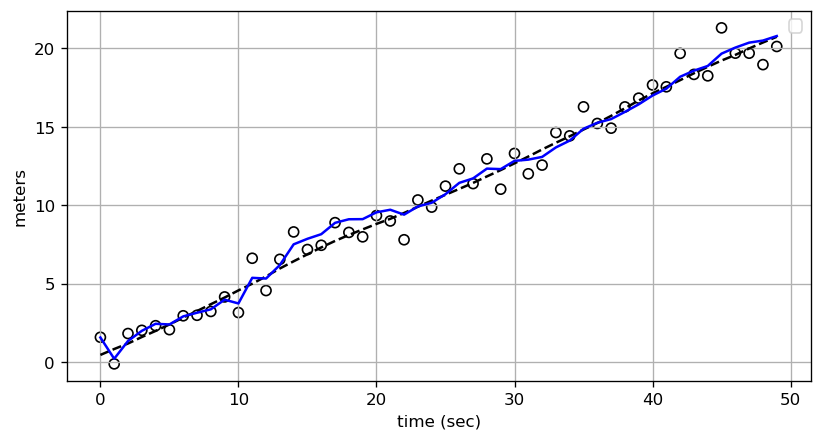

In [55]:
kf2_2 = SecondOrderKF(R_std=R,Q_std=0,dt=1.0)
data2_2 = filter_data(kf2_2,zs)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(list(range(50)),xs[:,0], c = 'black', linestyle="--") # track
ax.scatter(list(range(len(xs))),zs, fc='none', ec="black") # measurements
ax.plot(list(range(50)),data2_2.x[:,0], c='blue') # Filtered results
ax.set_xlabel('time (sec)')
ax.set_ylabel('meters')
ax.grid(visible=True)
plt.legend()
plt.show()

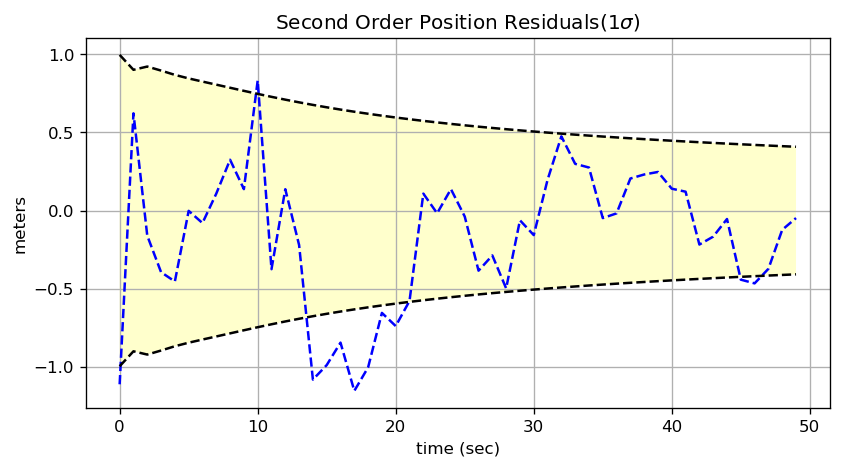

In [57]:
plot_residuals(xs[:,0], data2_2, 0, title="Second Order Position Residuals(1$\sigma$)", stds=1.0)

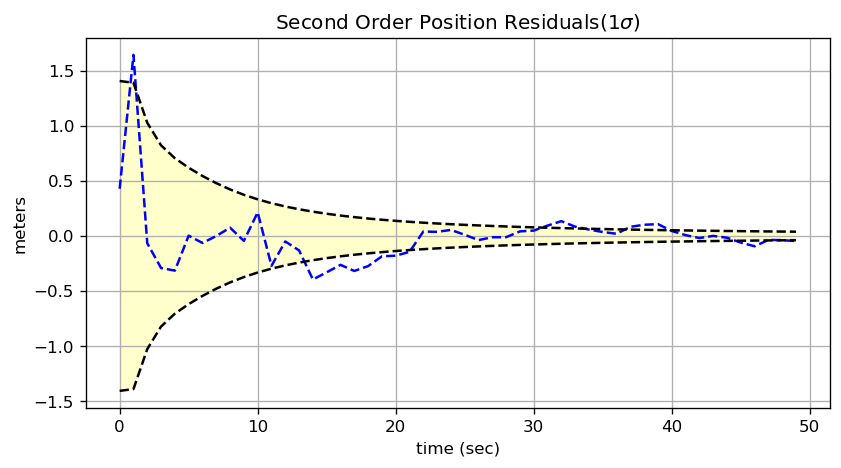

In [58]:
plot_residuals(xs[:,1], data2_2, 1, title="Second Order Position Residuals(1$\sigma$)", stds=1.0)

### Second Order with zero Q but more iteration/measurements

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


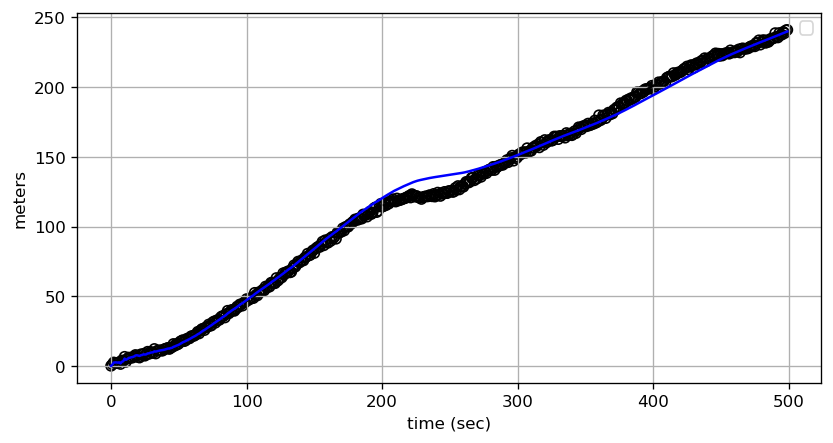

In [62]:
np.random.seed(25944)
xs500, zs500 = simulate_system(Q=Q, count = 500)

kf2_500 = SecondOrderKF(R_std=R, Q_std=0.0, dt=1.0)
data500 = filter_data(kf2_500, zs500)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(list(range(500)),xs500[:,0], c = 'black', linestyle="--") # track
ax.scatter(list(range(len(xs500))),zs500, fc='none', ec="black") # measurements
ax.plot(list(range(500)),data500.x[:,0], c='blue') # Filtered results
ax.set_xlabel('time (sec)')
ax.set_ylabel('meters')
ax.grid(visible=True)
plt.legend()
plt.show()

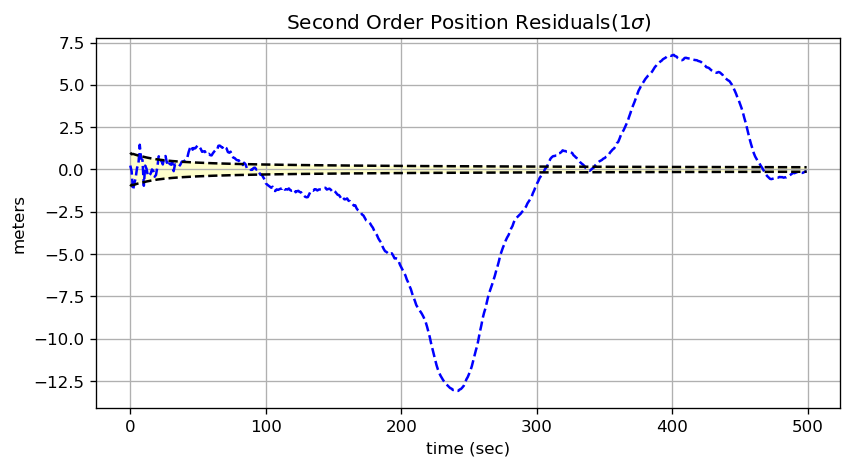

In [63]:
plot_residuals(xs500[:,0], data500, 0, title="Second Order Position Residuals(1$\sigma$)", stds=1.0)

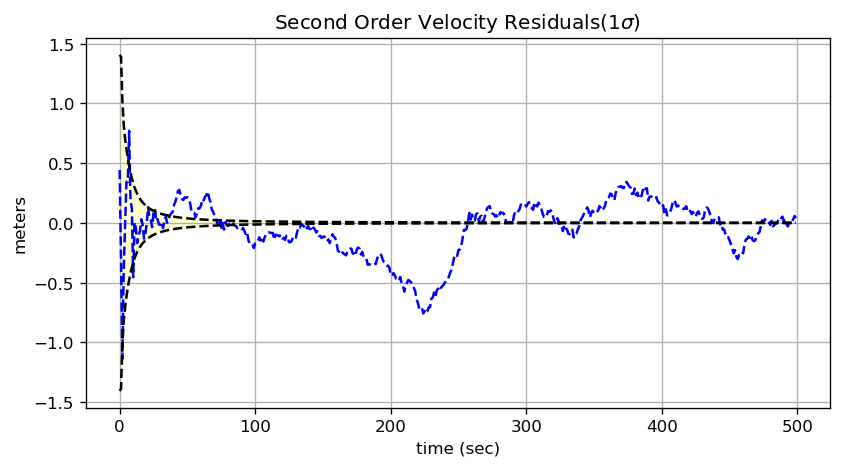

In [64]:
plot_residuals(xs500[:,1], data500, 1, title="Second Order Velocity Residuals(1$\sigma$)", stds=1.0)

### Second Order with really low Q but more iteration/measurements

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


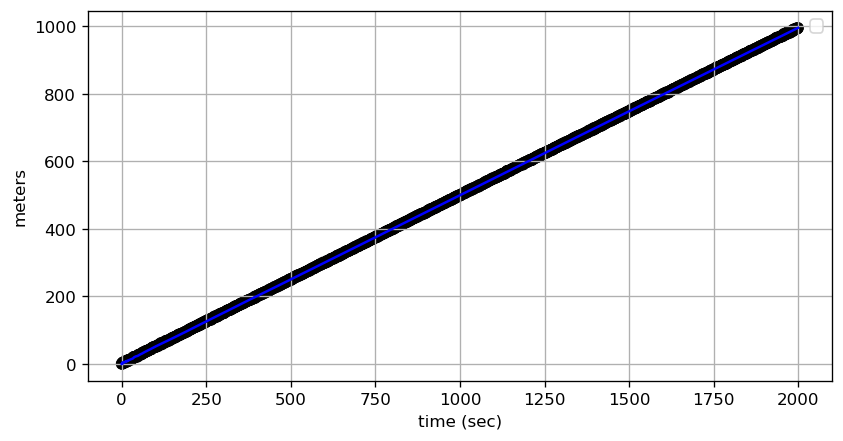

In [65]:
np.random.seed(32594)
xs2000, zs2000 = simulate_system(Q=0.0001, count = 2000)

kf2_2000 = SecondOrderKF(R_std=R, Q_std=0.0, dt=1.0)
data2000 = filter_data(kf2_2000, zs2000)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(list(range(2000)),xs2000[:,0], c = 'black', linestyle="--") # track
ax.scatter(list(range(len(xs2000))),zs2000, fc='none', ec="black") # measurements
ax.plot(list(range(2000)),data2000.x[:,0], c='blue') # Filtered results
ax.set_xlabel('time (sec)')
ax.set_ylabel('meters')
ax.grid(visible=True)
plt.legend()
plt.show()

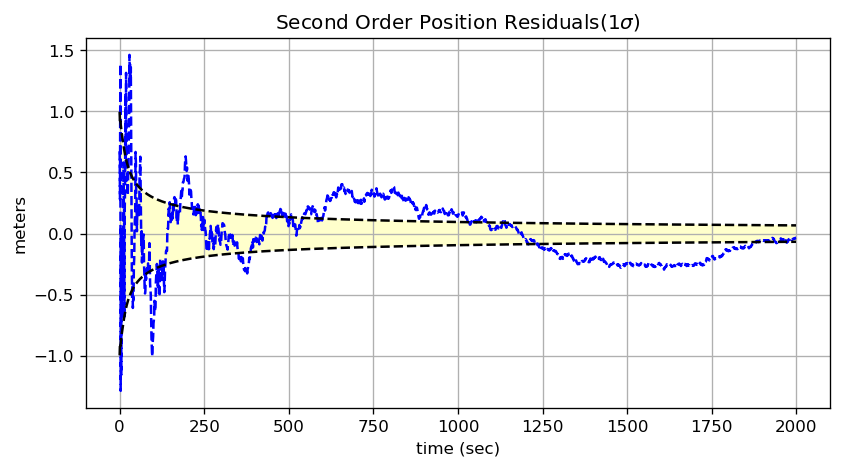

In [66]:
plot_residuals(xs2000[:,0], data2000, 0, title="Second Order Position Residuals(1$\sigma$)", stds=1.0)

# Using a lower order than the physical process

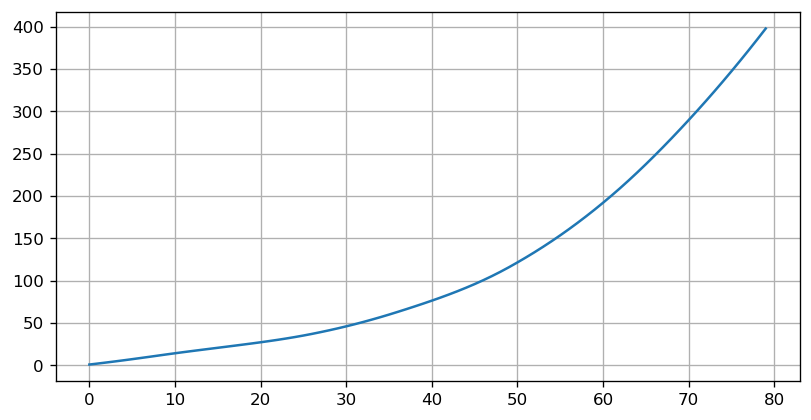

In [68]:
class ConstantAccelerationObject():
    def __init__(self, x0=0.0, vel=1.0, acc=0.1, acc_noise=0.1):
        self.x = x0
        self.vel = vel
        self.acc = acc
        self.acc_noise_scale = acc_noise

    def update(self):
        self.acc += np.random.randn() * self.acc_noise_scale
        self.vel += self.acc
        self.x += self.vel

        return (self.x,self.vel,self.acc)

def simulate_acc_system(R, Q, count):
    obj = ConstantAccelerationObject(acc_noise=Q)
    xs, zs = [], []
    for iteration in range(count):
        x = obj.update()
        z = sense(x,R)
        xs.append(x)
        zs.append(z)
    
    return np.asarray(xs), zs

np.random.seed(124)
R, Q = 6.0, 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(xs[:,0])
ax.grid(visible=True)
plt.show()

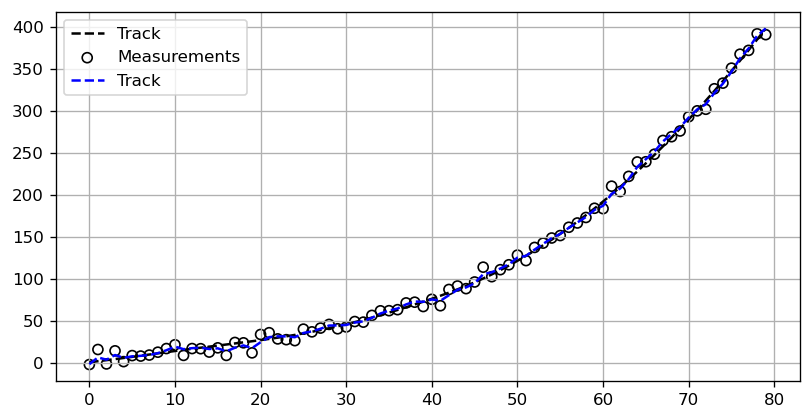

In [71]:
np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)

kf2_3 = SecondOrderKF(R, Q, dt=1)
data2_3 = filter_data(kf2_3, zs)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(xs[:,0], c = 'black', linestyle="--", label='Track')
ax.scatter(list(range(len(xs))),zs, fc="none", ec="black",label='Measurements')
ax.plot(data2_3.x[:,0], c = 'blue', linestyle="--", label='Track')
ax.grid(visible=True)
plt.legend()
plt.show()

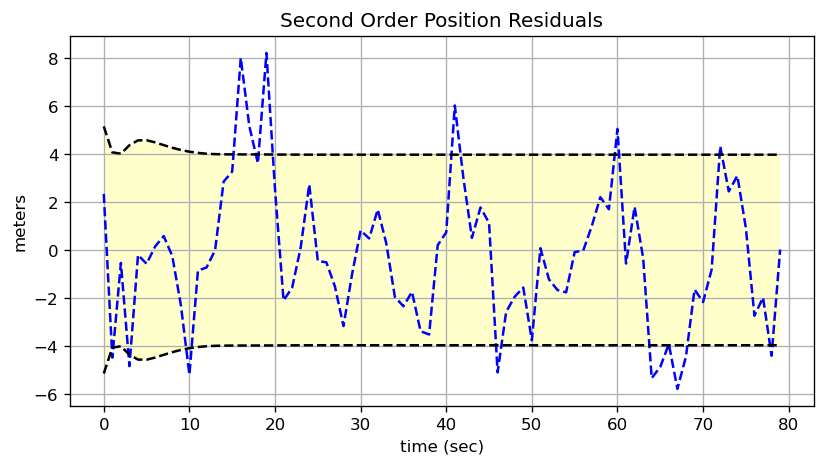

In [72]:
plot_residuals(xs[:,0], data2_3, 0, title="Second Order Position Residuals", stds=1.0)

### First Order on Accelerating object

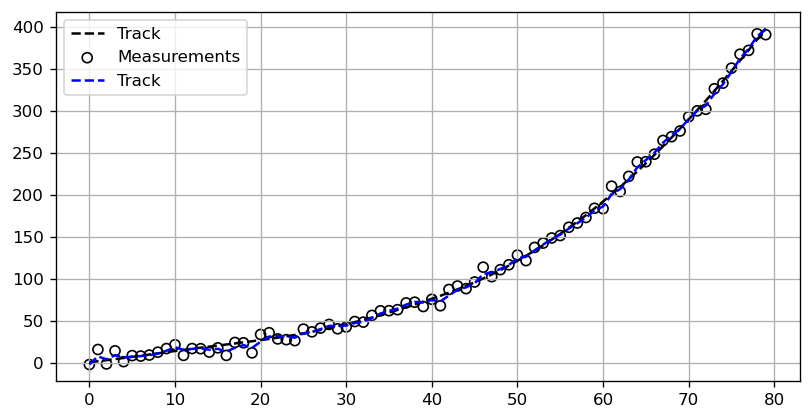

In [74]:
kf1_3 = FirstOrderKF(R, Q * 10, dt=1.0)
data1_3 = filter_data(kf1_3,zs)

fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.plot(xs[:,0], c = 'black', linestyle="--", label='Track')
ax.scatter(list(range(len(xs))),zs, fc="none", ec="black",label='Measurements')
ax.plot(data1_3.x[:,0], c = 'blue', linestyle="--", label='Track')
ax.grid(visible=True)
plt.legend()
plt.show()

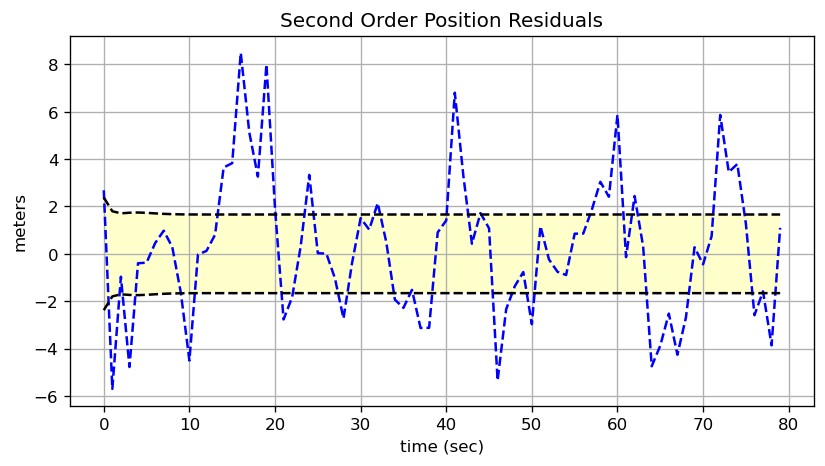

In [76]:
plot_residuals(xs[:,0], data1_3, 0, title="Second Order Position Residuals", stds=1.0)

# Tracking a ball (Introducing Constraints)

In [79]:
def rk4(x1,y1,dx,f):
    """Computes 4th order Runge-Kutta for dy/dx
    y = initial value for y
    x = initial value for x
    dx = change in x over a time step
    f is a callable function (x,y) that you supply to compute dy/dx for the specified values
    """

    k1 = dx * f(x1,y1)
    k2 = dx * f(x1 + 0.5*k1, y1 + 0.5*dx)
    k3 = dx * f(x1 + 0.5*k2, y1 + 0.5*dx)
    k4 = dx * f(x1 + k3, y1 + dx)

    return x1 + ((k1 + 2*k2 + 2*k3 + k4)/6.0)

def fx(x,t):
    return fx.vel

def fy(y,t):
    return fy.vel - 9.8*t

class BallTrajectory2D():
    def __init__(self, x0, y0, velocity, theta_deg=0.0, g=9.8, noise=[0.0,0.0]):
        self.x = x0
        self.y = y0
        self.t = 0
        theta = np.radians(theta_deg)
        fx.vel = np.cos(theta) * velocity
        fy.vel = np.sin(theta) * velocity
        self.g = g
        self.noise = noise

    def step(self, dt):
        self.x = rk4(self.t, self.x, dt, fx)
        self.y = rk4(self.t, self.y, dt, fy)
        self.t = self.t + dt
        return (self.x + np.random.randn()*self.noise[0],
                self.y + np.random.randn()*self.noise[1])

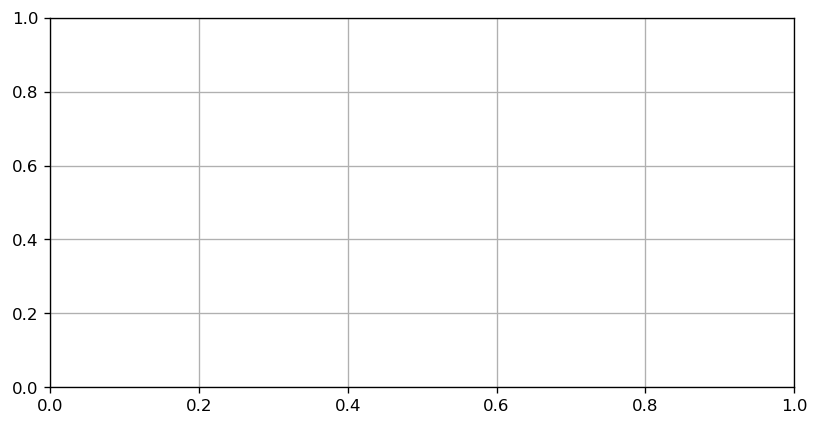

In [84]:
def test_ball_vacuum(noise):
    y = 15
    x = 0

    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=60.0, velocity=100.0, noise=noise)

    t = 0
    dt = 0.25
    
    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    ax.grid(visible=True)
    
    while y >= 0:
        x,y = ball.step(dt)
        t += dt
        if y >= 0:
            ax.scatter(x,y, fc="none", ec="black",label='Measurements')

    plt.show()

test_ball_vacuum([1,1])

In [85]:
x

(48.239395567975, 1.6404541006852227)

In [86]:
y

NameError: name 'y' is not defined